# Generate figures for the paper

We use this notebook to generate all figures for the paper. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cudams.utils import Timer
from pathlib import Path
from numba import cuda
import numpy as np
import matplotlib.pyplot as plt
from cudams.utils import download, get_correct_scores
from joblib import Parallel, delayed
from matchms.filtering import normalize_intensities, reduce_to_number_of_peaks, \
    select_by_mz, select_by_relative_intensity, require_minimum_number_of_peaks
from matchms.importing import load_from_mgf
from matchms.similarity import CosineGreedy, ModifiedCosine
from cudams.similarity import CudaCosineGreedy, CudaModifiedCosine
import seaborn as sns
from sklearn.linear_model import LinearRegression
from pathlib import Path
import json
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.random.seed(42)

plotting_style = {
    "figure.facecolor": "white",
    "text.color": ".15",
    "axes.labelcolor": ".15",
    "legend.frameon": False,
    "legend.numpoints": 1,
    "legend.scatterpoints": 1,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.color": ".15",
    "ytick.color": ".15",
    "axes.axisbelow": True,
    "image.cmap": "Greys",
    "font.family": "sans-serif",
    "font.sans-serif": [
        "Arial",
        "Liberation Sans",
        "DejaVu Sans",
        "Bitstream Vera Sans",
        "sans-serif",
    ],
    "grid.linestyle": "-",
    "lines.solid_capstyle": "round",
    "axes.grid": True,
    "axes.facecolor": "white",
    "axes.edgecolor": ".8",
    "axes.linewidth": 1,
    "grid.color": ".8",
    "xtick.major.size": 0,
    "ytick.major.size": 0,
    "xtick.minor.size": 0,
    "ytick.minor.size": 0,
    "figure.figsize": (4.9, 3.5),
    "font.size": 13.0,
    "axes.titlesize": "medium",
    "figure.titlesize": "medium",
}

plt.style.use(plotting_style)
assert cuda.is_available()

We define the limits for variables under investigation for the plots.

In [3]:
# We compare pairwise similarity performance on `spectra_file`
# We can use pickled version for much faster loading times
SPECTRA_FILE = 'GNPS-random-10k.mgf'

# spectra_file = "MASSBANK.mgf"  # Smaller set for faster runs

# How many spectra to sample for reference and query, this is quite small for a GPU, but we use
# it to keep MatchMS similarity fast, to obtain "correct" scores for equivalence compairson
N_SPECTRA = 512 * 5

# limits for testing tolerance influence on performance
MIN_TOLERANCE = 1e-6
MAX_TOLERANCE = 1000.0

# limits for testing match_limit influence on performance
MIN_MATCH_LIMIT = 8
MAX_MATCH_LIMIT = 2048 * 2

# limits for testing num peaks influence on performance
MIN_NUM_PEAKS = 32
MAX_NUM_PEAKS = 2048

# Max evals
NUM_EVALS = 16

# Default params
N_MAX_PEAKS = 1024

# Hardware matters! These results are only repeatable using this GPU (shown as an output)
! nvidia-smi -L
! echo Number of CPU cores $(nproc)

GPU 0: NVIDIA GeForce RTX 2070 with Max-Q Design (UUID: GPU-f6e241c8-f0ad-720e-be22-2713a6b0868d)
Number of CPU cores 12


## Default accuracy and performance

In [4]:
spectra = list(load_from_mgf(str(download(SPECTRA_FILE))))
spectra[:5]

[Spectrum(precursor m/z=827.32, 10 fragments between 79.1 and 137.1),
 Spectrum(precursor m/z=555.42, 75 fragments between 51.9 and 555.4),
 Spectrum(precursor m/z=520.36, 88 fragments between 47.1 and 522.4),
 Spectrum(precursor m/z=890.48, 1 fragments between 302.1 and 302.1),
 Spectrum(precursor m/z=385.16, 49 fragments between 50.1 and 386.2)]

# Accuracy with recommended filters

In [5]:
np.random.seed(42)

references = np.random.choice(
    spectra, 
    size=N_SPECTRA,
)

queries = np.random.choice(
    spectra,
    size=N_SPECTRA,
)

def process_spectrum(spectrum):
    """
    Suggested way to filter the given spectra.
    """
    spectrum = select_by_mz(spectrum, mz_from=10.0, mz_to=1000.0)
    spectrum = normalize_intensities(spectrum)
    spectrum = select_by_relative_intensity(spectrum, intensity_from=0.001)
    spectrum = reduce_to_number_of_peaks(spectrum, n_max=N_MAX_PEAKS)
    spectrum = require_minimum_number_of_peaks(spectrum, n_required=10)
    return spectrum

references = list(process_spectrum(s) for s in references)
references = list(r for r in references if r is not None)

queries = list(process_spectrum(s) for s in queries)
queries = list(r for r in queries if r is not None)

references[:5], queries[:5]

([Spectrum(precursor m/z=306.21, 26 fragments between 58.0 and 326.2),
  Spectrum(precursor m/z=195.09, 60 fragments between 50.6 and 201.5),
  Spectrum(precursor m/z=261.03, 11 fragments between 94.0 and 199.0),
  Spectrum(precursor m/z=872.77, 27 fragments between 91.9 and 841.8),
  Spectrum(precursor m/z=269.05, 23 fragments between 72.1 and 269.0)],
 [Spectrum(precursor m/z=443.13, 109 fragments between 55.1 and 445.2),
  Spectrum(precursor m/z=340.28, 78 fragments between 55.0 and 341.3),
  Spectrum(precursor m/z=211.00, 10 fragments between 69.0 and 211.0),
  Spectrum(precursor m/z=720.42, 162 fragments between 70.1 and 759.4),
  Spectrum(precursor m/z=525.28, 248 fragments between 78.5 and 405.2)])

### Greedy Cosine

In [6]:
batch_size = max(len(references), len(queries))

# Default arguments match in both...
scores = get_correct_scores(references=references, queries=queries, similarity_class=CosineGreedy)

In [7]:
scores_cu = CudaCosineGreedy(
    n_max_peaks = N_MAX_PEAKS,
    batch_size = batch_size,
).matrix(references, queries)

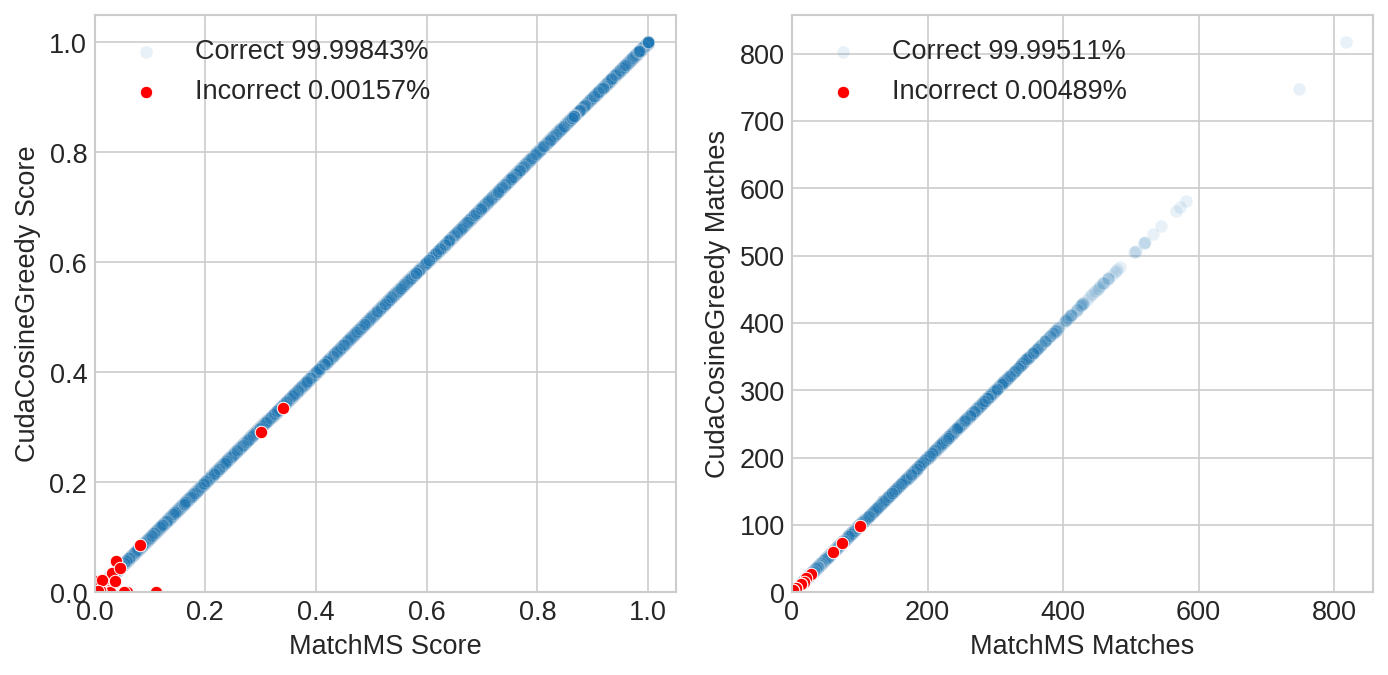

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(11, 5), dpi=150)
ax: plt.Axes = axs[0]

cudams_scores = scores_cu['score'].ravel()
matchms_scores = scores['score'].ravel()

is_correct = np.isclose(cudams_scores, matchms_scores, atol=.001)
is_wong = ~is_correct
is_overflow = scores_cu['overflow'].ravel() == 1
is_wrong_without_warning = is_wong & ~is_overflow
is_wrong_with_warning = is_wong & is_overflow

sns.scatterplot(x=cudams_scores[is_correct], 
                y=matchms_scores[is_correct], 
                alpha=.1,
                label=f'Correct {is_correct.mean()*100:.5f}%',
                ax=ax)

sns.scatterplot(x=matchms_scores[is_wrong_with_warning],
                y=cudams_scores[is_wrong_with_warning], 
                c='orange', 
                label=f'Overflow {is_wrong_with_warning.mean()*100:.5f}%',
                ax=ax
            )

sns.scatterplot(x=matchms_scores[is_wrong_without_warning],
                y=cudams_scores[is_wrong_without_warning], 
                c='red', 
                label=f'Incorrect {(is_wrong_without_warning).mean()*100:.5f}%', 
                ax=ax)

ax.legend(loc='upper left')
ax.set_xlabel(f"MatchMS Score")
ax.set_ylabel(f"CudaCosineGreedy Score")
ax.set_ylim([0, None])
ax.set_xlim([0, None])

ax = axs[1]
cudams_matches = scores_cu['matches'].ravel()
matchms_matches = scores['matches'].ravel()

is_correct = np.isclose(cudams_matches, matchms_matches, atol=.001)
is_wong = ~is_correct
is_overflow = scores_cu['overflow'].ravel() == 1
is_wrong_without_warning = is_wong & ~is_overflow
is_wrong_with_warning = is_wong & is_overflow

sns.scatterplot(x=matchms_matches[is_correct], 
                y=cudams_matches[is_correct], 
                alpha=.1,
                label=f'Correct {is_correct.mean()*100:.5f}%',
                ax=ax)

sns.scatterplot(x=matchms_matches[is_wrong_with_warning],
                y=cudams_matches[is_wrong_with_warning], 
                c='orange', 
                label=f'Overflow {is_wrong_with_warning.mean()*100:.5f}%',
                ax=ax
            )

sns.scatterplot(x=matchms_matches[is_wrong_without_warning],
                y=cudams_matches[is_wrong_without_warning], 
                c='red', 
                label=f'Incorrect {(is_wrong_without_warning).mean()*100:.5f}%', 
                ax=ax)

ax.legend(loc='upper left')
ax.set_xlabel(f"MatchMS Matches")
ax.set_ylabel(f"CudaCosineGreedy Matches")
ax.set_ylim([0, None])
ax.set_xlim([0, None])

# plt.suptitle("Direct Accuracy Comparison (Cosine Greedy)")
# plt.savefig('assets/accuracy.png')
plt.show()

### Modified Cosine

In [9]:
batch_size = max(len(references), len(queries))

scores = get_correct_scores(references=references, queries=queries, similarity_class=ModifiedCosine, tolerance=.1)

In [10]:
# from cudams.similarity import CudaModifiedCosine
scores_cu = CudaModifiedCosine(
    n_max_peaks = N_MAX_PEAKS,
    batch_size = batch_size
).matrix(references, queries)

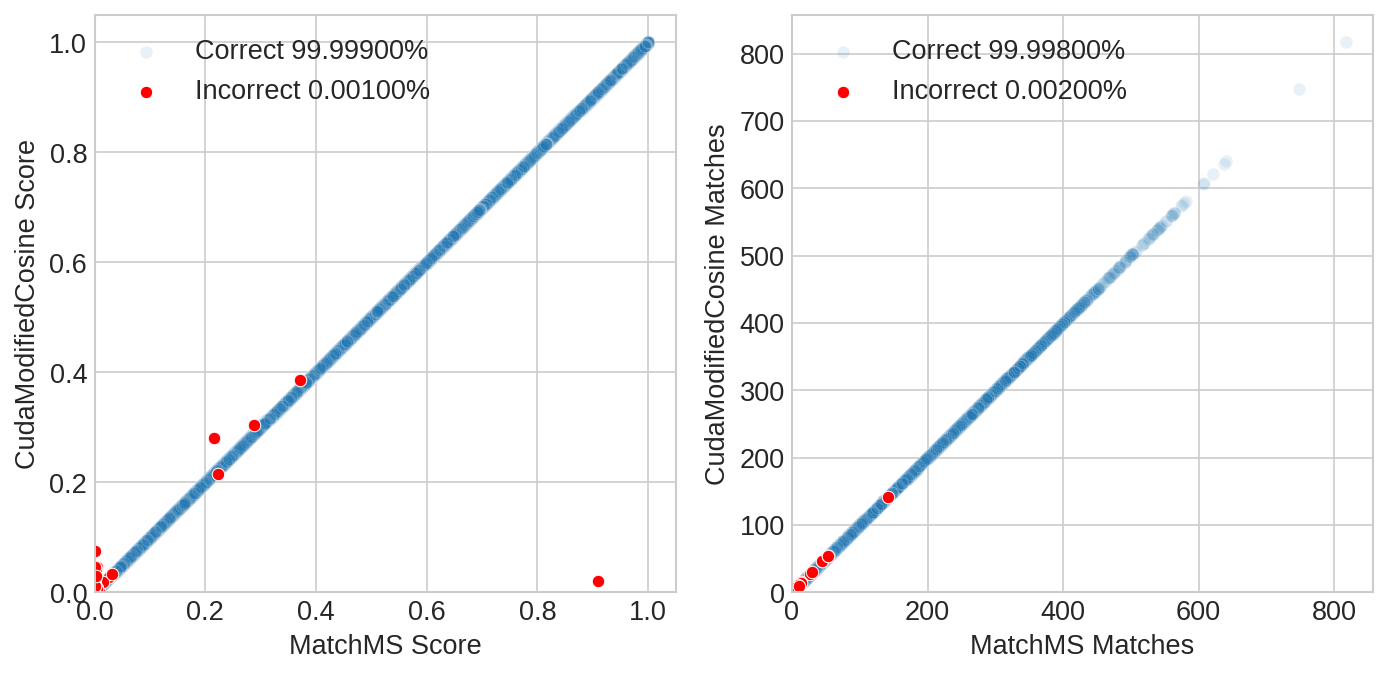

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(11, 5), dpi=150)
ax: plt.Axes = axs[0]

cudams_scores = scores_cu['score'].ravel()
matchms_scores = scores['score'].ravel()

is_correct = np.isclose(cudams_scores, matchms_scores, atol=.001)
is_wong = ~is_correct
is_overflow = scores_cu['overflow'].ravel() == 1
is_wrong_without_warning = is_wong & ~is_overflow
is_wrong_with_warning = is_wong & is_overflow

sns.scatterplot(x=cudams_scores[is_correct], 
                y=matchms_scores[is_correct], 
                alpha=.1,
                label=f'Correct {is_correct.mean()*100:.5f}%',
                ax=ax)

sns.scatterplot(x=matchms_scores[is_wrong_with_warning],
                y=cudams_scores[is_wrong_with_warning], 
                c='orange', 
                label=f'Overflow {is_wrong_with_warning.mean()*100:.5f}%',
                ax=axs
            )

sns.scatterplot(x=matchms_scores[is_wrong_without_warning],
                y=cudams_scores[is_wrong_without_warning], 
                c='red', 
                label=f'Incorrect {(is_wrong_without_warning).mean()*100:.5f}%', 
                ax=ax)

ax.legend(loc='upper left')
ax.set_xlabel(f"MatchMS Score")
ax.set_ylabel(f"CudaModifiedCosine Score")
ax.set_ylim([0, None])
ax.set_xlim([0, None])

ax = axs[1]
cudams_matches = scores_cu['matches'].ravel()
matchms_matches = scores['matches'].ravel()

is_correct = np.isclose(cudams_matches, matchms_matches, atol=.001)
is_wong = ~is_correct
is_overflow = scores_cu['overflow'].ravel() == 1
is_wrong_without_warning = is_wong & ~is_overflow
is_wrong_with_warning = is_wong & is_overflow

sns.scatterplot(x=matchms_matches[is_correct], 
                y=cudams_matches[is_correct], 
                alpha=.1,
                label=f'Correct {is_correct.mean()*100:.5f}%',
                ax=ax)

sns.scatterplot(x=matchms_matches[is_wrong_with_warning],
                y=cudams_matches[is_wrong_with_warning], 
                c='orange', 
                label=f'Overflow {is_wrong_with_warning.mean()*100:.5f}%',
                ax=ax
            )

sns.scatterplot(x=matchms_matches[is_wrong_without_warning],
                y=cudams_matches[is_wrong_without_warning], 
                c='red', 
                label=f'Incorrect {(is_wrong_without_warning).mean()*100:.5f}%', 
                ax=ax)

ax.legend(loc='upper left')
ax.set_xlabel(f"MatchMS Matches")
ax.set_ylabel(f"CudaModifiedCosine Matches")
ax.set_ylim([0, None])
ax.set_xlim([0, None])

# plt.suptitle("Direct Accuracy Comparison (Modified Cosine)")
# plt.savefig('assets/accuracy.png')
plt.show()

## Performance as a function of tolerance

### Greedy Cosine

In [14]:
np.random.seed(123)

references = np.random.choice(
    spectra, 
    size=256, 
    replace=False,
)

queries = np.random.choice(
    spectra,
    size=256,
    replace=False,
)
batch_size = max(len(references), len(queries))

tolerances = np.logspace(
    np.log10(MIN_TOLERANCE),
    np.log10(MAX_TOLERANCE), 
    endpoint=True,
    num=NUM_EVALS
)

jobs = []
for variable in tolerances:
    def loop(tolerance):
        tolerance = float(tolerance)
        scores = get_correct_scores(references=references, queries=queries, similarity_class=CosineGreedy, tolerance=tolerance)
        kernel = CudaCosineGreedy(
            tolerance=tolerance,
            batch_size=batch_size,
        )
        kernel.matrix(references[:4], queries[:4])
        with Timer() as t:
            scores_cu = kernel.matrix(references, queries)
        return scores, scores_cu, t.duration
    jobs.append(delayed(loop)(variable))
tolerance_perf_data = Parallel(1)(jobs)

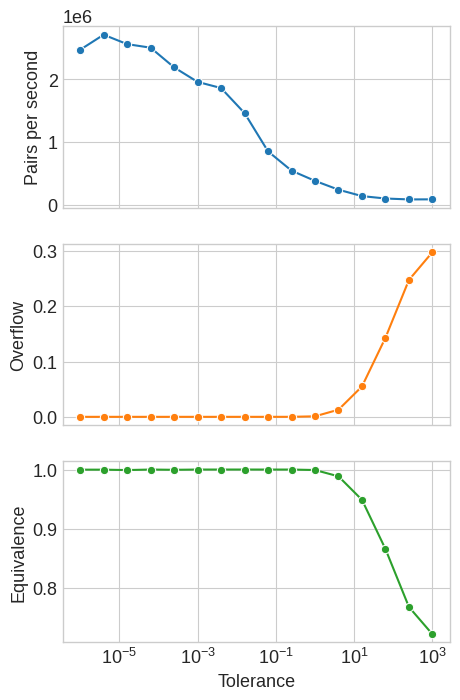

In [15]:
from typing import List

##### We use largest batch size for best error estimates
def plot_tol_and_perf(
    axis: List[plt.Axes] = None,
    data = None,
    tolerances=tolerances,
):
    ov_means = []
    match_means = []
    iseq_means = []
    spectra_per_second = []
    for scores, scores_cu, time_per_batch in data:
        a = scores['score'].ravel()
        am = scores['matches'].ravel()
        ov = scores_cu['overflow'].ravel() == 1
        b = scores_cu['score'].ravel()
        bm = scores_cu['matches'].ravel()
        iseq = np.isclose(a,b,atol=.001)
        
        ov_means.append(ov.mean())
        iseq_means.append(iseq.mean())
        match_means.append(bm.mean())
        pairs = len(references) * len(queries)
        spectra_per_second.append( pairs / time_per_batch )
    
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = list(prop_cycle.by_key()['color'])

    ax = axis[0]
    sns.lineplot(x=tolerances, 
                 y=spectra_per_second,
                 marker='o',
                 color=colors[0],
                 ax=ax)
    ax.set_ylabel("Pairs per second")
    ax.set_xscale('log')
    
    ax = axis[1]
    sns.lineplot(x=tolerances, 
                 y=ov_means,
                 marker='o',
                 color=colors[1],
                 ax=ax)
    
    ax.set_ylabel("Overflow")
    ax.set_xscale('log')
    
    ax = axis[2]
    sns.lineplot(x=tolerances,
                 y=iseq_means, 
                 marker='o',
                 color=colors[2],
                 ax=ax)
    
    ax.set_ylabel("Equivalence")
    ax.set_xscale('log')
    ax.set_xlabel("Tolerance")
    
fig, axd = plt.subplot_mosaic(
    [['a'],['b'],['c']], 
    figsize=(5, 8),
    sharex=True
)

plot_tol_and_perf(
    axis=[axd[k] for k in 'a b c'.split()], 
    data=tolerance_perf_data
)

## Match limit vs performance

In [16]:
np.random.seed(111)

match_limits = np.logspace(
    np.log10(MIN_MATCH_LIMIT),
    np.log10(MAX_MATCH_LIMIT), 
    endpoint=True,
    num=NUM_EVALS
)

references = np.random.choice(
    spectra,  
    size=256,
    replace=False,
)

queries = np.random.choice(
    spectra,
    size=256,
    replace=False,
)
batch_size = max(len(references), len(queries))
scores = get_correct_scores(references=references, queries=queries, similarity_class=CosineGreedy, tolerance=.1)

In [17]:
jobs = []
for variable in match_limits:
    def loop(match_limit):
        match_limit = int(match_limit)
        kernel = CudaCosineGreedy(
            match_limit=match_limit,
            batch_size=batch_size
        )
        kernel.matrix(references[:4], queries[:4])
        with Timer() as t:
            scores_cu = kernel.matrix(references, queries)
        return scores, scores_cu, t.duration
    jobs.append(delayed(loop)(variable))
match_limit_data = Parallel(1)(jobs)

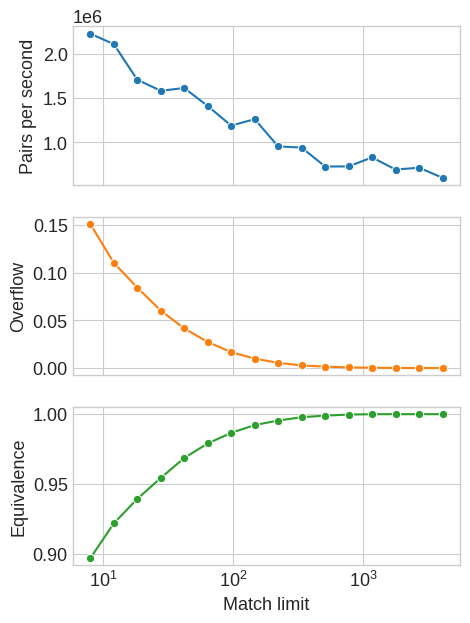

In [18]:
def plot_ml_and_perf(
    axis:List[plt.Axes]=None,
    match_limits=match_limits, 
    data=None
):
    ov_means = []
    match_means = []
    iseq_means = []
    pairs_per_second = []
    for (scores, scores_cu, duration) in data:
        a = scores['score'].ravel()
        am = scores['matches'].ravel()
        ov = scores_cu['overflow'].ravel() == 1
        b = scores_cu['score'].ravel()
        bm = scores_cu['matches'].ravel()
        iseq = np.isclose(a,b,atol=.001)
        
        ov_means.append(ov.mean())
        iseq_means.append(iseq.mean())
        match_means.append(bm.mean())
        pairs_per_second.append((len(references) * len(queries))/duration)
    
    
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = iter(list(prop_cycle.by_key()['color']))

    ax = axis[0]
    sns.lineplot(x=match_limits, 
                 y=pairs_per_second,
                 color=next(colors),
                 marker='o',
                 ax=ax)
    ax.set_ylabel("Pairs per second")
    
    ax = axis[1]
    sns.lineplot(x=match_limits, 
                 y=ov_means,
                 color=next(colors),
                 marker='o',
                 ax=ax)
    ax.set_ylabel("Overflow")
    
    ax = axis[2]
    sns.lineplot(x=match_limits,
                 y=iseq_means, 
                 marker='o',
                 color=next(colors),
                 ax=ax)
    # thresh_idx = np.searchsorted(iseq_means, .999)
    ax.set_ylabel("Equivalence")
    ax.set_xscale('log')
    ax.set_xlabel("Match limit")
    # ax.text(.05, 0.95, 'c', transform=ax.transAxes, fontsize=12,
    #          verticalalignment='top', horizontalalignment='right',
    #          bbox=dict(facecolor='white', alpha=0.5))
    
fig, axd = plt.subplot_mosaic(
    [['a'],['b'],['c']], 
    figsize=(5, 7),
    sharex=True
)

plot_ml_and_perf(
    axis=[axd[k] for k in 'a b c'.split()],
    data=match_limit_data,
)

# Performance plots

Requires us to run notebooks under `notebooks/figures/performance` first, to generate performance accross multiple GPU types.

MatchMS dict_keys(['cells', 'metadata', 'nbformat', 'nbformat_minor'])
Colab_T4 dict_keys(['cells', 'metadata', 'nbformat', 'nbformat_minor'])
RTX4090 dict_keys(['cells', 'metadata', 'nbformat', 'nbformat_minor'])
A100PCIE dict_keys(['cells', 'metadata', 'nbformat', 'nbformat_minor'])


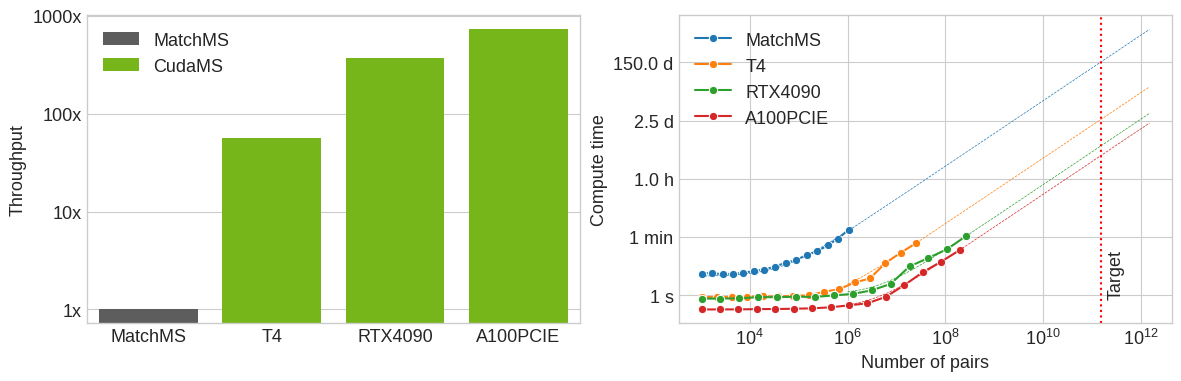

In [19]:
performance_data = []
get_approach_name = {'matchms': 'MatchMS', 'colab': 'T4', 
                  'rtx4090': 'RTX4090', 'a100pcie':'A100PCIE'}

# For each notebook...
for nb in sorted(Path('notebooks/figures/performance/').glob('*.ipynb')):

    # Read the last cell's output as a JSON...
    method = nb.stem.split('_on_')[-1]
    nb_data = json.loads(nb.read_text())
    print(method, nb_data.keys())
    res = json.loads(' '.join(nb_data['cells'][-1]['outputs'][0]['text']))
    # And save into a dictionary
    res['method'] = method
    res['pairs'] = res.get('pairs_cu', res.get('pairs'))
    res['times'] = res.get('times_cu', res.get('times'))
    res.pop('pairs_cu', None)
    res.pop('times_cu', None)

    # Each cell result contains multiple-sized runs, flatten all results into one big dataframe
    for r in range(len(res['pairs'])):
        if 'cpu' in method:
            res['device'] = 'v32CPU'
        performance_data.append({
            'pairs': res['pairs'][r],
            'times': res['times'][r],
            'device': res['device'],
            'nproc': res['nproc'],
            'method': method
        })
df = pd.DataFrame(performance_data)

# For all sizes of experiments...
pairs_scale = np.logspace(np.log2(df.pairs.min()), 
                          np.log2(df.pairs.max()),
                          base=2,
                          dtype='float64',
                          num=50)

# Plot performance onto the same grid, 
# NOTE: *Crucially* we extrapolate performance lines using linear regresion, to avoid actually wating for several days.
def plot_perf(ax: plt.Axes, df: pd.DataFrame=df):
    plt.sca(ax)
    perf_at_axvline = []
    for name in get_approach_name:
        gr = df[df['method'].str.lower().str.contains(name)]
        if 'matchms' in name:
            full_range = np.logspace(np.log10(1000), np.log10(100_000 * 1_500_000 * 10), 50).reshape(-1, 1)
        else:
            full_range = np.logspace(np.log10(1_000_000), np.log10(100_000 * 1_500_000 * 10), 50).reshape(-1, 1)

        estimate_next = LinearRegression(positive=True)
        estimate_next.fit(np.array(gr[['pairs']]), np.array(gr[['times']]))
        estim_perf = estimate_next.predict(full_range)

        art = sns.lineplot(x=gr.pairs, 
                           y=gr.times, 
                           marker='o', label=get_approach_name[name], ax=ax)

        sns.lineplot(x=full_range.ravel(), 
                     y=estim_perf.ravel(), 
                     linestyle='--',
                     linewidth=.5,
                     color=art.lines[-1].get_color(), ax=ax)
        goal_num = 100_000 * 1_500_000
        perf_at_axvline.append([get_approach_name[name],  goal_num / estimate_next.predict([[goal_num]]).item() ])

    # Our "target" is a real-world usecase we are facing, that we developed this kernel for.
    ax.axvline(goal_num, 0, 1, color='red', linestyle=':', )
    ax.text(goal_num * 1.4, 1, f'Target', rotation=90)
    ax.set_xlabel("Number of pairs")
    ax.set_ylabel("Compute time")
    ax.set_xscale('log')
    ax.set_yscale('log', base=60)
    
    # Fancy formatter for time...
    def _formatter(v: float, p) -> str:
        if v < 60:  # Less than a minute
            return f"{v:.0f} s"
        elif v < 3600:  # Less than an hour
            return f"{v / 60:.0f} min"
        elif v < 86400:  # Less than a day
            return f"{v / 3600:.1f} h"
        else:
            return f"{v / 86400:.1f} d"
    ax.yaxis.set_major_formatter(plt.FuncFormatter(_formatter))
    ax.grid(True, 'major', axis='y')


def plot_perf_at_goal(ax: plt.Axes, df: pd.DataFrame=df):
    plt.sca(ax)
    perf_at_axvline = []
    gr_matchms = df[df['method'].str.lower().str.contains('matchms')]
    estimate_matchms = LinearRegression(positive=True)
    estimate_matchms.fit(np.array(gr_matchms[['pairs']]), np.array(gr_matchms[['times']]))
    goal_num = 100_000 * 1_500_000
    matchms_speed = (1 / estimate_matchms.predict([[goal_num]]).item())

    for name in get_approach_name:
        gr = df[df['method'].str.lower().str.contains(name)]
        estimate = LinearRegression(positive=True)
        estimate.fit(np.array(gr[['pairs']]), np.array(gr[['times']]))
        goal_num = 100_000 * 1_500_000
        speed = (1 / estimate.predict([[goal_num]]).item())
        relative_speedup = speed / matchms_speed
        perf_at_axvline.append([get_approach_name[name], relative_speedup])    
    x, y = zip(*perf_at_axvline)
    hue = ['MatchMS', 'CudaMS', 'CudaMS', 'CudaMS']
    sns.barplot(x=x, y=y, ax=ax, hue=hue, palette=['#5d5d5d', '#7cd000'])
    ax.set_ylabel("Throughput")
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter((lambda v,p: f'{int(v)}x'))
    ax.grid(True, 'major', axis='y')

fig, axs = plt.subplots(1, 2, figsize=(14, 4))

ax = axs[0]
plot_perf_at_goal(ax)

ax = axs[1]
plot_perf(ax)
plt.savefig('assets/perf.svg')
plt.show()

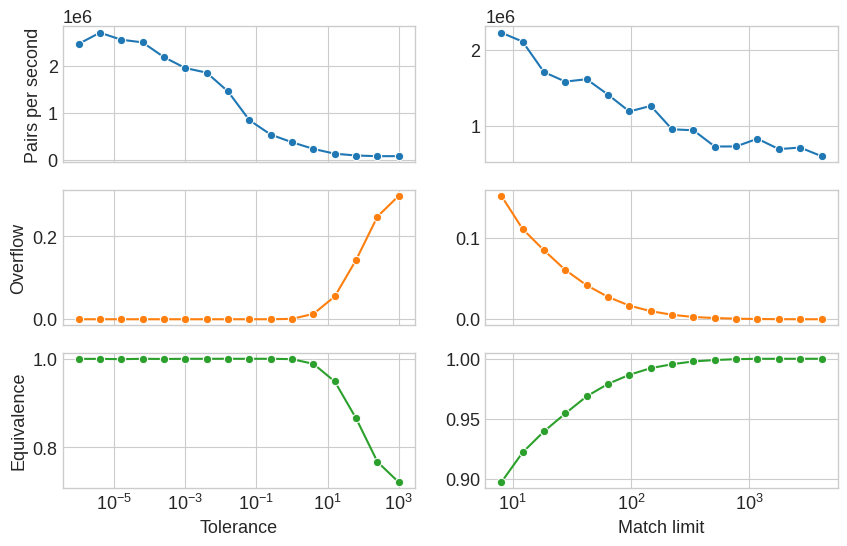

In [20]:
fig, axd = plt.subplot_mosaic(
    [['a','A'],
     ['b','B'],
     ['c','C']], 
    figsize=(10,6),
)

plot_tol_and_perf(
    axis=[axd[k] for k in 'a b c'.split()], 
    data=tolerance_perf_data
)

# match limit
plot_ml_and_perf(
    axis=[axd[k] for k in 'A B C'.split()], 
    data=match_limit_data
)
[axd[k].set_ylabel(None) for k in 'A B C'.split()];
[axd[k].set_xscale('log') for k in 'A B'.split()];
[axd[k].set_xticklabels([]) for k in 'A B'.split()];
[axd[k].set_xticklabels([]) for k in 'a b'.split()];
plt.savefig('plot.png')